In [1]:
import qiskit

In [2]:
from qiskit import IBMQ
IBMQ.save_account('c81b6ab5c814d3a62d6c5e9b6fd7bb399a602777eb49f83e1578c6928a03819c462cd75b67812ca14d3e48733e00525180a6cda445774766f5d012c1758a10ec', overwrite=True)

In [4]:
pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

  Cloning https://github.com/qiskit-community/qiskit-textbook.git to c:\users\anirudh\appdata\local\temp\pip-req-build-11ps03l1

  Created wheel for qiskit-textbook: filename=qiskit_textbook-0.1.0-py3-none-any.whl size=17069 sha256=d7858434286b2e5b76172fcd71a06c85feff19a4d3ff4c8d0328283be1fd20af
  Stored in directory: C:\Users\ANIRUDH\AppData\Local\Temp\pip-ephem-wheel-cache-czfr20ax\wheels\80\c4\dd\b7ea1ee2a7247e8997db78bc777bbe22e61ab1e5ed1c4b46e1
Successfully built qiskit-textbook


In [5]:
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute

In [6]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

def get_noise(p):

    error_meas = pauli_error([('X',p), ('I', 1 - p)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
        
    return noise_model


In [7]:
noise_model = get_noise(0.01)

In [8]:
for state in ['00','01','10','11']:
    qc = QuantumCircuit(2,2)
    if state[0]=='1':
        qc.x(1)
    if state[1]=='1':
        qc.x(0)  
    qc.measure(qc.qregs[0],qc.cregs[0])
    print(state+' becomes',
          execute(qc, Aer.get_backend('qasm_simulator'),noise_model=noise_model,shots=10000).result().get_counts())


00 becomes {'00': 9782, '01': 114, '10': 102, '11': 2}
01 becomes {'00': 114, '01': 9780, '10': 1, '11': 105}
10 becomes {'00': 91, '01': 2, '10': 9816, '11': 91}
11 becomes {'00': 1, '01': 114, '10': 89, '11': 9796}


In [9]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)  
qc.measure(qc.qregs[0],qc.cregs[0])
print(execute(qc, Aer.get_backend('qasm_simulator'),noise_model=noise_model,shots=10000).result().get_counts())


{'00': 4822, '01': 109, '10': 100, '11': 4969}


In [10]:
import numpy as np

M = [[0.9808,0.0107,0.0095,0.0001],
    [0.0095,0.9788,0.0001,0.0107],
    [0.0096,0.0002,0.9814,0.0087],
    [0.0001,0.0103,0.0090,0.9805]]

Cideal = [[5000],
          [0],
          [0],
          [5000]]

Cnoisy = np.dot(M, Cideal)
print('C_noisy =\n',Cnoisy)


C_noisy =
 [[4904.5]
 [ 101. ]
 [  91.5]
 [4903. ]]


In [11]:
import scipy.linalg as la

M = [[0.9808,0.0107,0.0095,0.0001],
    [0.0095,0.9788,0.0001,0.0107],
    [0.0096,0.0002,0.9814,0.0087],
    [0.0001,0.0103,0.0090,0.9805]]

Minv = la.inv(M)

print(Minv)


[[ 1.01978044e+00 -1.11470783e-02 -9.87135367e-03  1.05228426e-04]
 [-9.89772783e-03  1.02188470e+00  9.39504466e-05 -1.11514471e-02]
 [-9.97422955e-03 -4.05845410e-06  1.01913199e+00 -9.04172099e-03]
 [ 9.15212840e-05 -1.07335657e-02 -9.35458279e-03  1.02008794e+00]]


In [12]:
Cmitigated = np.dot(Minv, Cnoisy)
print('C_mitigated =\n',Cmitigated)

C_mitigated =
 [[ 5.00000000e+03]
 [-1.75779530e-14]
 [ 2.65169831e-14]
 [ 5.00000000e+03]]


In [15]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)

In [16]:
qr = QuantumRegister(2)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')


In [17]:
for circuit in meas_calibs:
    print('Circuit',circuit.name)
    print(circuit)
    print()

Circuit mcalcal_00
        ░ ┌─┐   
q10_0: ─░─┤M├───
        ░ └╥┘┌─┐
q10_1: ─░──╫─┤M├
        ░  ║ └╥┘
 c0: 2/════╩══╩═
           0  1 

Circuit mcalcal_01
       ┌───┐ ░ ┌─┐   
q10_0: ┤ X ├─░─┤M├───
       └───┘ ░ └╥┘┌─┐
q10_1: ──────░──╫─┤M├
             ░  ║ └╥┘
 c0: 2/═════════╩══╩═
                0  1 

Circuit mcalcal_10
             ░ ┌─┐   
q10_0: ──────░─┤M├───
       ┌───┐ ░ └╥┘┌─┐
q10_1: ┤ X ├─░──╫─┤M├
       └───┘ ░  ║ └╥┘
 c0: 2/═════════╩══╩═
                0  1 

Circuit mcalcal_11
       ┌───┐ ░ ┌─┐   
q10_0: ┤ X ├─░─┤M├───
       ├───┤ ░ └╥┘┌─┐
q10_1: ┤ X ├─░──╫─┤M├
       └───┘ ░  ║ └╥┘
 c0: 2/═════════╩══╩═
                0  1 



In [18]:
# Execute the calibration circuits without noise
backend = Aer.get_backend('qasm_simulator')
job = execute(meas_calibs, backend=backend, shots=1000)
cal_results = job.result()


In [19]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)


[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [21]:
noise_model = get_noise(0.1)

In [22]:
backend = Aer.get_backend('qasm_simulator')
job = execute(meas_calibs, backend=backend, shots=1000, noise_model=noise_model)
cal_results = job.result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)


[[0.799 0.077 0.097 0.006]
 [0.08  0.806 0.01  0.077]
 [0.107 0.013 0.811 0.092]
 [0.014 0.104 0.082 0.825]]


In [23]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)  
qc.measure(qc.qregs[0],qc.cregs[0])

results = execute(qc, backend=backend, shots=10000, noise_model=noise_model).result()

noisy_counts = results.get_counts()
print(noisy_counts)


{'00': 4090, '01': 986, '10': 890, '11': 4034}


In [24]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)


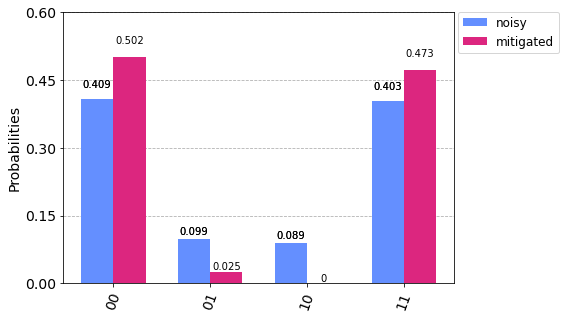

In [26]:
from qiskit.visualization import plot_histogram
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])